# Exploring and Visualizing OpenAQ Data

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import openaq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_theme(style="darkgrid")

from shapely.geometry import Point

import geopandas as gpd
from geopandas import GeoDataFrame

import geoplot as gplt
import geoplot.crs as gcrs

import fiona

ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/envs/aqproject/share/proj failed


In [2]:
api = openaq.OpenAQ()
resp = api.cities(df=True, limit=10000)

In [3]:
resp.query('city.str.contains("San") and country.str.contains("US")', engine='python')

,country,name,city,count,locations
145,US,Atlanta-Sandy Springs-Marietta,Atlanta-Sandy Springs-Marietta,1904583,13
1380,US,Los Angeles-Long Beach-Santa Ana,Los Angeles-Long Beach-Santa Ana,5563662,32
2032,US,Riverside-San Bernardino-Ontario,Riverside-San Bernardino-Ontario,5439639,42
2098,US,San Antonio,San Antonio,514007,8
2106,US,San Diego-Carlsbad-San Marcos,San Diego-Carlsbad-San Marcos,1007213,11
2112,US,San Francisco Bay Area,San Francisco Bay Area,152929,1
2113,US,San Francisco-Oakland-Fremont,San Francisco-Oakland-Fremont,4656913,15
2115,US,San Jose-Sunnyvale-Santa Clara,San Jose-Sunnyvale-Santa Clara,1312842,8
2118,US,San Juan-Caguas-Guaynabo,San Juan-Caguas-Guaynabo,8475,1
2125,US,San Luis Obispo-Paso Robles,San Luis Obispo-Paso Robles,1613186,34


In [4]:
res = api.locations(city='San Francisco-Oakland-Fremont', df=True)

<AxesSubplot:>

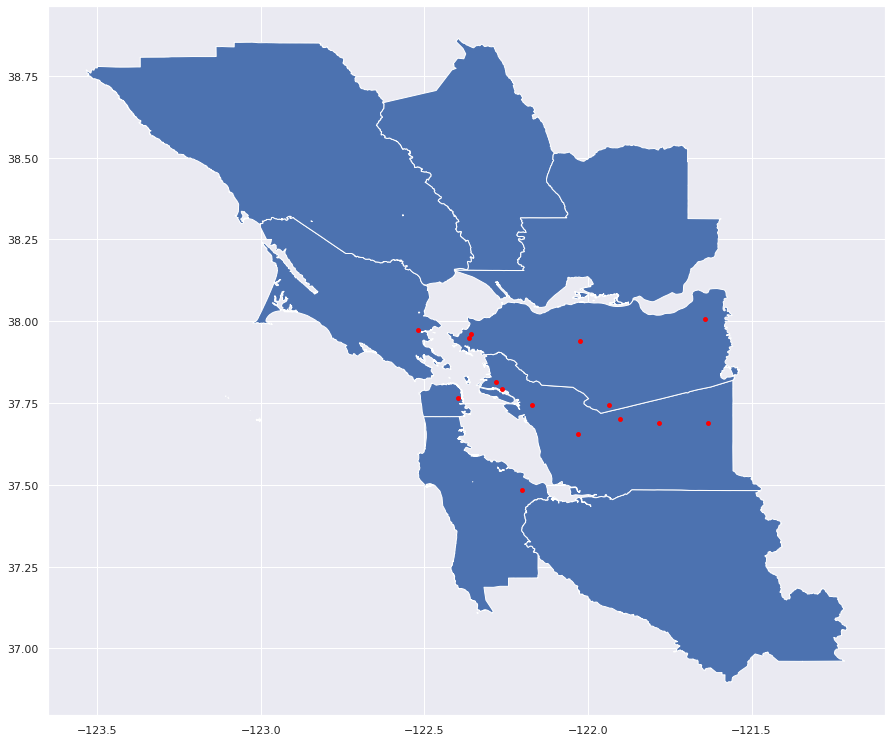

In [5]:
geometry = [Point(xy) for xy in zip(res['coordinates.longitude'], res['coordinates.latitude'])]
gdf = GeoDataFrame(res, geometry=geometry)
world = gpd.read_file("https://data.sfgov.org/api/geospatial/s9wg-vcph?method=export&format=Shapefile")
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15)

In [6]:
measure = api.measurements(city='San Francisco-Oakland-Fremont', parameter='pm25', limit=1000, df=True)

# Print out the statistics on a per-location basiss
measure.groupby(['location'])['value'].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Concord,102.0,5.294118,2.369728,-1.0,4.0,5.0,7.0,11.0
Laney College,70.0,5.685714,2.287603,0.0,4.0,6.0,7.0,10.0
Livermore - Rincon,106.0,5.132075,2.556320,0.0,3.0,5.0,7.0,12.0
Oakland,103.0,5.815534,2.099242,1.0,4.0,6.0,7.0,11.0
Oakland West,105.0,4.809524,2.357864,-1.0,3.0,5.0,7.0,11.0
Pleasanton - Owens C,102.0,5.588235,2.762381,-1.0,4.0,5.0,7.0,14.0
Redwood City,104.0,4.048077,3.095188,-3.0,2.0,4.0,5.0,15.0
San Francisco,104.0,5.586538,3.293449,-1.0,3.0,6.0,8.0,17.0
San Pablo - Rumrill,99.0,10.414141,8.164145,3.0,6.0,8.0,10.5,43.0


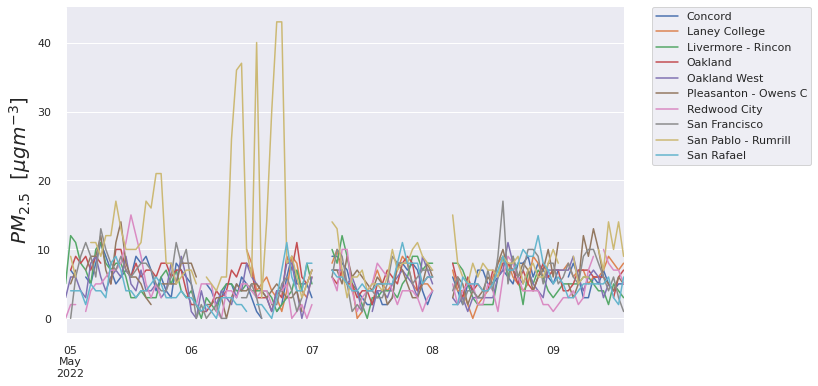

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))

for group, df in measure.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()

    _df.value.plot(ax=ax, label=group)

ax.legend(loc='best')
ax.set_ylabel("$PM_{2.5}$  [$\mu g m^{-3}$]", fontsize=20)
ax.set_xlabel("")
sns.despine(offset=5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

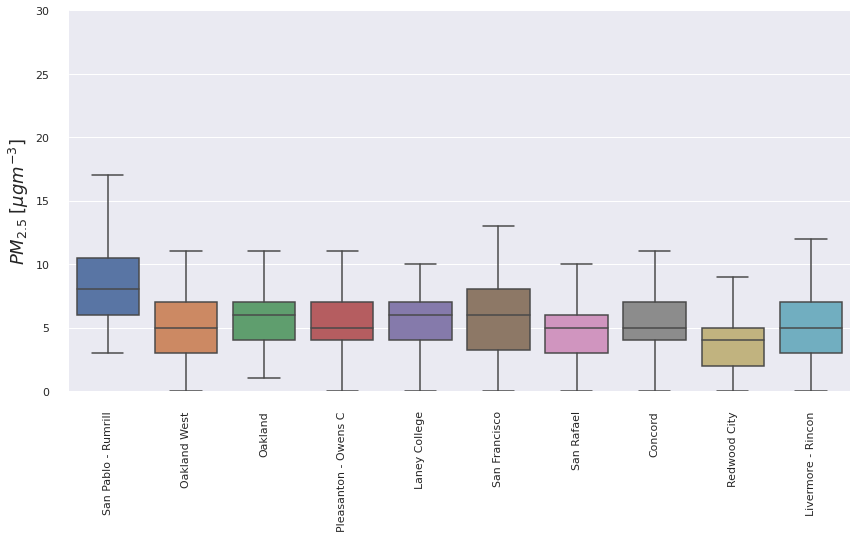

In [8]:
fig, ax = plt.subplots(1, figsize=(14,7))

ax = sns.boxplot(
    x='location',
    y='value',
    data=measure.query("value >= 0.0"),
    fliersize=0,
    palette='deep',
    ax=ax)

ax.set_ylim([0, 30])
ax.set_ylabel("$PM_{2.5}\;[\mu gm^{-3}]$", fontsize=18)
ax.set_xlabel("")

sns.despine(offset=10)

plt.xticks(rotation=90)
plt.show()

In [9]:
sanfrancisco = api.locations(city='San Francisco-Oakland-Fremont', df=True)


sanfrancisco.iloc[0]


id                                                                    1311
country                                                                 US
city                                         San Francisco-Oakland-Fremont
cities                                     [San Francisco-Oakland-Fremont]
location                                                     Laney College
locations                                                  [Laney College]
sourceName                                                          AirNow
sourceNames                                                       [AirNow]
sourceType                                                      government
sourceTypes                                                   [government]
firstUpdated                                     2016-03-06 19:00:00+00:00
lastUpdated                                      2022-05-09 21:00:00+00:00
parameters                                             [bc, pm25, co, no2]
countsByMeasurement      

In [10]:
dark_day_sf_pm25 = api.measurements(location='San Francisco', parameter='pm25', date_from='2020-09-07', date_to='2020-09-13', df=True, limit=1000)
dark_day_sf_pm25.head()

,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude
date.local,,,,,,,,,
2020-09-12 17:00:00,San Francisco,pm25,77,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-13 00:00:00+00:00,37.7658,-122.3978
2020-09-12 16:00:00,San Francisco,pm25,78,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 23:00:00+00:00,37.7658,-122.3978
2020-09-12 15:00:00,San Francisco,pm25,77,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 22:00:00+00:00,37.7658,-122.3978
2020-09-12 14:00:00,San Francisco,pm25,83,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 21:00:00+00:00,37.7658,-122.3978
2020-09-12 13:00:00,San Francisco,pm25,87,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 20:00:00+00:00,37.7658,-122.3978


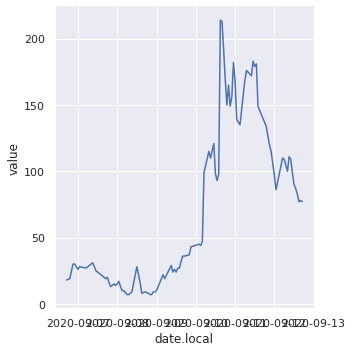

In [11]:
g = sns.relplot(x=dark_day_sf_pm25.index, y='value', kind='line', data=dark_day_sf_pm25)
#g.set(xticks=range(len(dark_day_sf_pm25.index)+1))

In [12]:
dark_max = dark_day_sf_pm25[dark_day_sf_pm25.value == dark_day_sf_pm25.value.max()]
dark_max

,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude
date.local,,,,,,,,,
2020-09-10 15:00:00,San Francisco,pm25,214,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-10 22:00:00+00:00,37.7658,-122.3978


In [13]:
test = api.measurements(city='San Francisco-Oakland-Fremont', date_from='2020-09-07', date_to='2020-09-08', df=True, limit=1000)
test = test[test['parameter'] == 'pm25']
test = test[test['date.utc'] == '2020-09-07 13:00:00+00:00']
test

,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude
date.local,,,,,,,,,
2020-09-07 06:00:00,Concord,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.938300,-122.025000
2020-09-07 06:00:00,Laney College,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.793624,-122.263376
2020-09-07 06:00:00,Livermore - Rincon,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.687526,-121.784217
2020-09-07 06:00:00,Redwood City,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.482800,-122.202200
2020-09-07 06:00:00,Oakland West,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.814800,-122.282402
2020-09-07 06:00:00,San Rafael,pm25,18.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.972200,-122.518900
2020-09-07 06:00:00,Oakland,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.743061,-122.169907
2020-09-07 06:00:00,Pleasanton - Owens C,pm25,32.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.701222,-121.903019
2020-09-07 06:00:00,San Pablo - Rumrill,pm25,16.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.960400,-122.357100


In [14]:
geometry = [Point(xy) for xy in zip(test['coordinates.longitude'], test['coordinates.latitude'])]
gdf = GeoDataFrame(test, geometry=geometry)

gdf


,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude,geometry
date.local,,,,,,,,,,
2020-09-07 06:00:00,Concord,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.938300,-122.025000,POINT (-122.02500 37.93830)
2020-09-07 06:00:00,Laney College,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.793624,-122.263376,POINT (-122.26338 37.79362)
2020-09-07 06:00:00,Livermore - Rincon,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.687526,-121.784217,POINT (-121.78422 37.68753)
2020-09-07 06:00:00,Redwood City,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.482800,-122.202200,POINT (-122.20220 37.48280)
2020-09-07 06:00:00,Oakland West,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.814800,-122.282402,POINT (-122.28240 37.81480)
2020-09-07 06:00:00,San Rafael,pm25,18.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.972200,-122.518900,POINT (-122.51890 37.97220)
2020-09-07 06:00:00,Oakland,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.743061,-122.169907,POINT (-122.16991 37.74306)
2020-09-07 06:00:00,Pleasanton - Owens C,pm25,32.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.701222,-121.903019,POINT (-121.90302 37.70122)
2020-09-07 06:00:00,San Pablo - Rumrill,pm25,16.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.960400,-122.357100,POINT (-122.35710 37.96040)


Text(0.5, 1.0, 'Bay Area pm25 on ')

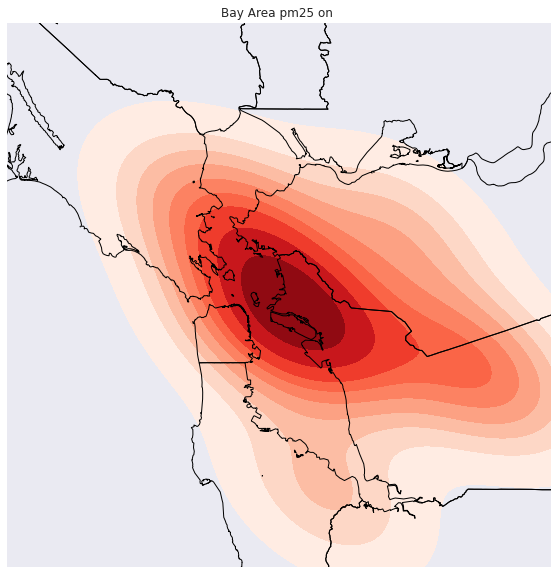

In [15]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection=proj)

gplt.kdeplot(
    gdf,
    cmap='Reds',
    projection=proj,
    shade=True, thresh=0.05,
    ax=ax1
)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

In [16]:
USlocs = api.locations(country='US', df=True, limit=10000)

USlocs.head()

,id,country,city,cities,location,locations,sourceName,sourceNames,sourceType,sourceTypes,firstUpdated,lastUpdated,parameters,countsByMeasurement,count,coordinates.latitude,coordinates.longitude
0,212,US,Fort Smith,[Fort Smith],ROLAND,[ROLAND],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 21:00:00+00:00,"[pm10, o3, no2, pm25]","[{'parameter': 'pm10', 'count': 5}, {'paramete...",204889,35.408138,-94.524414
1,213,US,TWIN FALLS,[TWIN FALLS],Twin Falls PM25,"[Twin Falls 1405 TEOM, Twin Falls PM25]",AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 21:00:00+00:00,[pm25],"[{'parameter': 'pm25', 'count': 104036}]",104036,42.565089,-114.494717
2,215,US,TUSCOLA,[TUSCOLA],Unionville,[Unionville],AirNow,[AirNow],government,[government],2016-03-11 22:00:00+00:00,2022-05-09 21:00:00+00:00,[o3],"[{'parameter': 'o3', 'count': 80415}]",80415,43.610000,-83.360000
3,216,US,South Bend-Mishawaka,[South Bend-Mishawaka],South Bend-Shields D,[South Bend-Shields D],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 21:00:00+00:00,"[pm25, o3, no2]","[{'parameter': 'pm25', 'count': 40363}, {'para...",212896,41.696700,-86.214700
4,218,US,Chicago-Naperville-Joliet,[Chicago-Naperville-Joliet],Ogden Dunes,[Ogden Dunes],AirNow,[AirNow],government,[government],2016-03-13 05:00:00+00:00,2022-05-09 21:00:00+00:00,"[pm25, o3]","[{'parameter': 'pm25', 'count': 1}, {'paramete...",89448,41.617500,-87.199200


In [17]:
filter1 = USlocs[USlocs['coordinates.latitude'] > 37.]
filter2= filter1[filter1['coordinates.latitude'] < 38.]
filter3 = filter2[filter2['coordinates.longitude'] < -121.3]
filter4 = filter3[filter3['coordinates.longitude'] > -123.]
filter5 = filter4[filter4['firstUpdated'] < '2020-09-07 00:00:00+00:00']
bay_area_locs = filter5[filter5['lastUpdated'] > '2020-09-13 00:00:00+00:00']
bay_area_locs

,id,country,city,cities,location,locations,sourceName,sourceNames,sourceType,sourceTypes,firstUpdated,lastUpdated,parameters,countsByMeasurement,count,coordinates.latitude,coordinates.longitude
251,793,US,Stockton,[Stockton],TracyAP,[TracyAP],AirNow,[AirNow],government,[government],2016-03-10 07:00:00+00:00,2022-05-09 21:00:00+00:00,"[no2, pm10, o3, pm25]","[{'parameter': 'no2', 'count': 64799}, {'param...",310539,37.682500,-121.440600
532,1311,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],Laney College,[Laney College],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 21:00:00+00:00,"[bc, pm25, co, no2]","[{'parameter': 'bc', 'count': 98410}, {'parame...",382159,37.793624,-122.263376
661,1518,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],Livermore - Rincon,[Livermore - Rincon],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 21:00:00+00:00,"[o3, bc, no2, pm25]","[{'parameter': 'o3', 'count': 92587}, {'parame...",372858,37.687526,-121.784217
700,1577,US,San Jose-Sunnyvale-Santa Clara,[San Jose-Sunnyvale-Santa Clara],Los Gatos,[Los Gatos],AirNow,[AirNow],government,[government],2016-04-01 17:00:00+00:00,2022-05-09 21:00:00+00:00,[o3],"[{'parameter': 'o3', 'count': 91147}]",91147,37.226700,-121.978600
944,1950,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],Concord,[Concord],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 21:00:00+00:00,"[no2, so2, o3, pm25, co]","[{'parameter': 'no2', 'count': 89746}, {'param...",457762,37.938300,-122.025000
978,2001,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],San Ramon,[San Ramon],AirNow,[AirNow],government,[government],2016-04-01 17:00:00+00:00,2022-05-09 21:00:00+00:00,"[o3, no2]","[{'parameter': 'o3', 'count': 93520}, {'parame...",186839,37.743649,-121.934188
979,2002,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],San Rafael,[San Rafael],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 21:00:00+00:00,"[no2, o3, co, pm25]","[{'parameter': 'no2', 'count': 90161}, {'param...",372207,37.972200,-122.518900
980,2003,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],San Pablo - Rumrill,[San Pablo - Rumrill],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 21:00:00+00:00,"[co, pm25, no2, o3, so2]","[{'parameter': 'co', 'count': 90535}, {'parame...",451875,37.960400,-122.357100
981,2004,US,San Jose-Sunnyvale-Santa Clara,[San Jose-Sunnyvale-Santa Clara],San Martin,[San Martin],AirNow,[AirNow],government,[government],2016-04-01 17:00:00+00:00,2022-05-09 21:00:00+00:00,[o3],"[{'parameter': 'o3', 'count': 90215}]",90215,37.079200,-121.599400
982,2007,US,San Jose-Sunnyvale-Santa Clara,[San Jose-Sunnyvale-Santa Clara],San Jose - Knox Ave,[San Jose - Knox Ave],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 21:00:00+00:00,"[co, no2, bc, pm25]","[{'parameter': 'co', 'count': 95896}, {'parame...",380687,37.338202,-121.849892


In [18]:
city_list = bay_area_locs.reset_index()
dark_days_data = {}
for index, row in city_list.iterrows():
    location = row['location']
    coords = (row['coordinates.longitude'], row['coordinates.latitude'])
    if row['parameters'].count('pm25') == 0:
        continue
    if row['city'] == 'Santa Cruz-Watsonville':
        continue
    table = api.measurements(location=location, parameter='pm25', 
                             date_from='2020-09-07', date_to='2020-09-13', df=True, limit=1000)
    table = table.reset_index()
    date_vals = dict(list(zip(table['date.local'], table['value'])))
    dark_days_data[location] = list()
    dark_days_data[location].append(coords)
    dark_days_data[location].append(date_vals)
    print(location)

TracyAP
Laney College
Livermore - Rincon
Concord
San Rafael
San Pablo - Rumrill
San Jose - Knox Ave
San Jose - Jackson S
San Francisco
Oakland
Oakland West
Redwood City
Pleasanton - Owens C
Berkeley Aquatic Par


In [19]:
df = pd.DataFrame.from_dict(dark_days_data['TracyAP'][1], orient='index', columns=['TracyAP'])
for key in dark_days_data.keys():
    df2 = pd.DataFrame.from_dict(dark_days_data[key][1], orient='index', columns=[key])
    df = pd.concat([df, df2], axis=1)
df = df.iloc[: , 1:]
df.head()

,TracyAP,Laney College,Livermore - Rincon,Concord,San Rafael,San Pablo - Rumrill,San Jose - Knox Ave,San Jose - Jackson S,San Francisco,Oakland,Oakland West,Redwood City,Pleasanton - Owens C,Berkeley Aquatic Par
2020-09-06 17:00:00,61.0,37.0,71.0,68.0,25.0,43.0,73.0,83.0,18.0,39.0,26.0,60.0,58.0,27.0
2020-09-06 19:00:00,NaN,29.0,62.0,24.0,15.0,39.0,41.0,27.0,19.0,35.0,23.0,39.0,54.0,22.0
2020-09-06 21:00:00,47.0,23.0,56.0,29.0,15.0,38.0,44.0,45.0,30.0,44.0,19.0,27.0,45.0,25.0
2020-09-06 22:00:00,NaN,20.0,41.0,30.0,10.0,25.0,51.0,51.0,30.0,44.0,22.0,38.0,53.0,22.0
2020-09-07 00:00:00,NaN,28.0,40.0,25.0,20.0,25.0,54.0,52.0,26.0,34.0,25.0,42.0,47.0,30.0


In [20]:
df = df.interpolate(method='linear', limit_direction='forward', axis=0)
df.head()

,TracyAP,Laney College,Livermore - Rincon,Concord,San Rafael,San Pablo - Rumrill,San Jose - Knox Ave,San Jose - Jackson S,San Francisco,Oakland,Oakland West,Redwood City,Pleasanton - Owens C,Berkeley Aquatic Par
2020-09-06 17:00:00,61.000000,37.0,71.0,68.0,25.0,43.0,73.0,83.0,18.0,39.0,26.0,60.0,58.0,27.0
2020-09-06 19:00:00,54.000000,29.0,62.0,24.0,15.0,39.0,41.0,27.0,19.0,35.0,23.0,39.0,54.0,22.0
2020-09-06 21:00:00,47.000000,23.0,56.0,29.0,15.0,38.0,44.0,45.0,30.0,44.0,19.0,27.0,45.0,25.0
2020-09-06 22:00:00,47.333333,20.0,41.0,30.0,10.0,25.0,51.0,51.0,30.0,44.0,22.0,38.0,53.0,22.0
2020-09-07 00:00:00,47.666667,28.0,40.0,25.0,20.0,25.0,54.0,52.0,26.0,34.0,25.0,42.0,47.0,30.0


In [21]:
df.size

1568

In [22]:
name_list = []
coord_list = []
for key in dark_days_data.keys():
    name_list.append(key)
    coord_list.append(dark_days_data[key][0])

geometry = [Point(xy) for xy in coord_list]
cities_coords = GeoDataFrame(name_list, geometry=geometry)
cities_coords

,0,geometry
0,TracyAP,POINT (-121.44060 37.68250)
1,Laney College,POINT (-122.26338 37.79362)
2,Livermore - Rincon,POINT (-121.78422 37.68753)
3,Concord,POINT (-122.02500 37.93830)
4,San Rafael,POINT (-122.51890 37.97220)
5,San Pablo - Rumrill,POINT (-122.35710 37.96040)
6,San Jose - Knox Ave,POINT (-121.84989 37.33820)
7,San Jose - Jackson S,POINT (-121.89470 37.34830)
8,San Francisco,POINT (-122.39780 37.76580)
9,Oakland,POINT (-122.16991 37.74306)


In [23]:
temp = cities_coords.set_index([0])
for i in range(df.shape[0]):
    dftemp =  pd.DataFrame(df.iloc[i])
    temp = pd.concat([temp, dftemp], axis=1)
bay_area_dark_days_data = temp


In [24]:
bay_area_dark_days_data_text = bay_area_dark_days_data
bay_area_dark_days_data_text.columns = bay_area_dark_days_data_text.columns.astype(str)
bay_area_dark_days_data_text.to_file('bayareadarkdays.geojson', driver='GeoJSON')  

In [25]:
bay_data = gpd.read_file('bayareadarkdays.geojson')

In [26]:
col_list = bay_data.columns
dark_day_cols = [col for col in bay_data.columns if '2020-09-09' in col]
dark_max = [col for col in bay_data.columns if '2020-09-10 15:00:00' in col]
def plotter(i):
    plot_data = bay_data[['index',col_list[i], 'geometry']]
    gplt.kdeplot(
    plot_data,
    cmap='Reds',
    projection=proj,
    shade=True, thresh=0.05,
    ax=ax1)
    plt.show()

plotter(2)

In [27]:
lats = []
lons = []
for i in range(len(coord_list)):
    lats.append(coord_list[i][1])
    lons.append(coord_list[i][0])
    
data= pd.DataFrame()
data['Lat'] = lats
data['Lon'] = lons
data

,Lat,Lon
0,37.682500,-121.440600
1,37.793624,-122.263376
2,37.687526,-121.784217
3,37.938300,-122.025000
4,37.972200,-122.518900
5,37.960400,-122.357100
6,37.338202,-121.849892
7,37.348300,-121.894700
8,37.765800,-122.397800
9,37.743061,-122.169907


/home/jovyan/envs/aqproject/lib/python3.10/site-packages/geoplot/geoplot.py:248: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(
/home/jovyan/envs/aqproject/lib/python3.10/site-packages/geoplot/geoplot.py:248: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(


Text(0.5, 1.0, 'Bay Area pm25 on ')

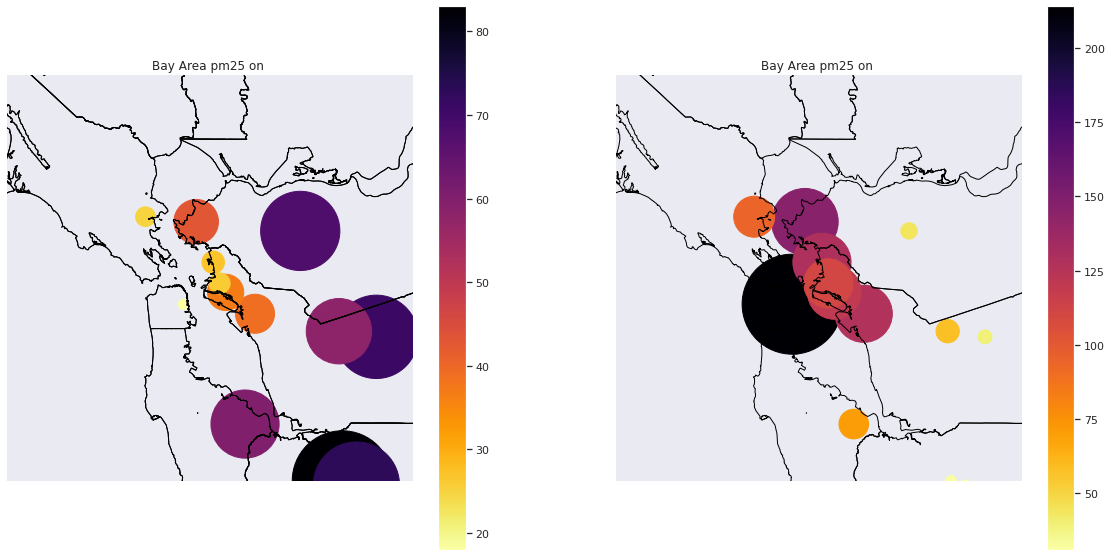

In [41]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(20, 10))
ax1 = plt.subplot(121, projection=proj)
ax2 = plt.subplot(122, projection=proj)


# gplt.kdeplot(
#     bay_data[['index', 'geometry']],
#     cmap='Reds',
#     projection=proj,
#     shade=True, bw=1,
#     ax=ax1, n_levels=20, weights=bay_data[col_list[1]]
# )
gplt.pointplot(bay_data, projection=proj, hue=col_list[1], legend=True,scale=col_list[1], limits=(10, 100), cmap='inferno_r', ax=ax1)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

# gplt.kdeplot(
#     bay_data[['index', 'geometry']],
#     cmap='Reds',
#     projection=proj,
#     shade=True, bw=1,
#     ax=ax2, n_levels=20, weights=bay_data[dark_max[0]]
# )
gplt.pointplot(bay_data, projection=proj, hue=dark_max[0], legend=True,scale=dark_max[0], limits=(10, 100), cmap='inferno_r', ax=ax2)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")
gplt.polyplot(world, zorder=1, ax=ax2)
ax2.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax2.set_title("Bay Area pm25 on ")

<Figure size 432x288 with 0 Axes>

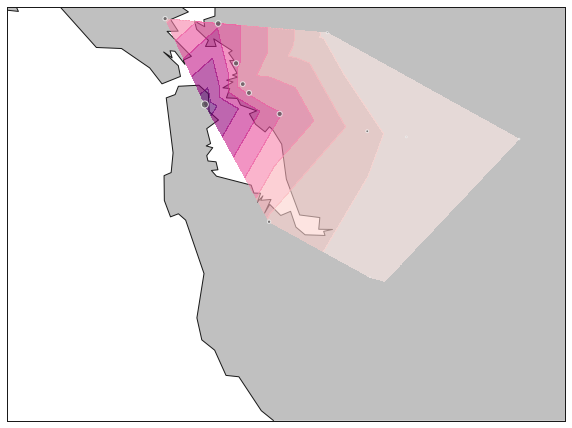

In [39]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

# set up plot
plt.clf()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, frame_on=False)

# grab data
data['Z'] = bay_data[dark_max[0]]

norm = Normalize()

# define map extent
lllon = -123
lllat = 37
urlon = -121.3
urlat = 38


# Set up Basemap instance
m = Basemap(
    projection = 'merc',
    llcrnrlon = lllon, llcrnrlat = lllat, urcrnrlon = urlon, urcrnrlat = urlat,
    resolution='i')

# transform lon / lat coordinates to map projection
data['projected_lon'], data['projected_lat'] = m(*(data.Lon.values, data.Lat.values))

# # grid data
numcols, numrows = 1000, 1000
xi = np.linspace(data['projected_lon'].min(), data['projected_lon'].max(), numcols)
yi = np.linspace(data['projected_lat'].min(), data['projected_lat'].max(), numrows)
xi, yi = np.meshgrid(xi, yi)

# # interpolate
x, y, z = data['projected_lon'].values, data['projected_lat'].values, data.Z.values
zi = griddata((x, y), z, (xi, yi))

# # draw map details
m.drawmapboundary(fill_color = 'white')
m.fillcontinents(color='#C0C0C0', lake_color='#7093DB')
m.drawcountries(
    linewidth=.75, linestyle='solid', color='#000073',
    antialiased=True,
    ax=ax, zorder=3)
m.drawcoastlines()


# # contour plot
con = m.contourf(xi, yi, zi, zorder=4, alpha=0.6, cmap='RdPu')
# scatter plot
m.scatter(
    data['projected_lon'],
    data['projected_lat'],
    color='#545454',
    edgecolor='#ffffff',
    alpha=.75,
    s=50 * norm(data['Z']),
    ax=ax,
    vmin=zi.min(), vmax=zi.max(), zorder=20)

# # add colour bar and title
# # add colour bar, title, and scale
# cbar = plt.colorbar(orientation='horizontal', fraction=.057, pad=0.05)
# cbar.set_label("Mean Rainfall - mm")

# m.drawmapscale(
#     24., -9., 28., -13,
#     100,
#     units='km', fontsize=10,
#     yoffset=None,
#     barstyle='fancy', labelstyle='simple',
#     fillcolor1='w', fillcolor2='#000000',
#     fontcolor='#000000',
#     zorder=5)

# # plt.title("Mean Rainfall")
# plt.show()

In [31]:
data

,Lat,Lon,Z,projected_lon,projected_lat
0,37.682500,-121.440600,84.0,173397.286960,95456.530024
1,37.793624,-122.263376,27.0,81908.813075,111081.411185
2,37.687526,-121.784217,51.0,135188.837842,96162.717939
3,37.938300,-122.025000,52.0,108415.002428,131459.220995
4,37.972200,-122.518900,20.0,53495.854018,136239.877476
5,37.960400,-122.357100,24.0,71487.184678,134575.563802
6,37.338202,-121.849892,32.0,127886.114474,47193.536892
7,37.348300,-121.894700,26.0,122903.694547,48605.893513
8,37.765800,-122.397800,22.5,66961.553294,107166.942689
9,37.743061,-122.169907,26.0,92302.086780,103968.959853


/home/jovyan/envs/aqproject/lib/python3.10/site-packages/geoplot/geoplot.py:248: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(


Text(0.5, 1.0, 'Bay Area pm25 on ')

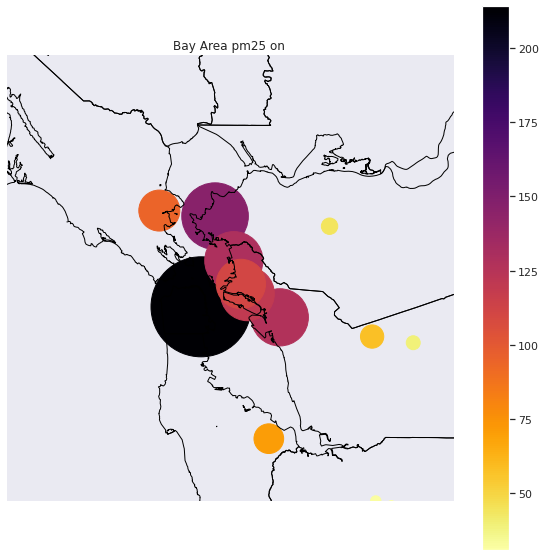

In [32]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection=proj)

gplt.pointplot(bay_data, projection=proj, hue=dark_max[0], legend=True,scale=dark_max[0], limits=(10, 100), cmap='inferno_r', ax=ax1)
# gplt.kdeplot(
#     bay_data[['index',col_list[1], 'geometry']],
#     cmap='Reds',
#     projection=proj,
#     shade=True,
#     ax=ax1, n_levels=20
# )
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

In [33]:
bay_data[['index',col_list[1], 'geometry']]

,index,2020-09-06 17:00:00,geometry
0,TracyAP,61.0,POINT (-121.44060 37.68250)
1,Laney College,37.0,POINT (-122.26338 37.79362)
2,Livermore - Rincon,71.0,POINT (-121.78422 37.68753)
3,Concord,68.0,POINT (-122.02500 37.93830)
4,San Rafael,25.0,POINT (-122.51890 37.97220)
5,San Pablo - Rumrill,43.0,POINT (-122.35710 37.96040)
6,San Jose - Knox Ave,73.0,POINT (-121.84989 37.33820)
7,San Jose - Jackson S,83.0,POINT (-121.89470 37.34830)
8,San Francisco,18.0,POINT (-122.39780 37.76580)
9,Oakland,39.0,POINT (-122.16991 37.74306)


In [34]:
bay_data[['index',dark_max[0], 'geometry']]

,index,2020-09-10 15:00:00,geometry
0,TracyAP,39.0,POINT (-121.44060 37.68250)
1,Laney College,120.0,POINT (-122.26338 37.79362)
2,Livermore - Rincon,39.0,POINT (-121.78422 37.68753)
3,Concord,44.0,POINT (-122.02500 37.93830)
4,San Rafael,94.0,POINT (-122.51890 37.97220)
5,San Pablo - Rumrill,146.0,POINT (-122.35710 37.96040)
6,San Jose - Knox Ave,31.0,POINT (-121.84989 37.33820)
7,San Jose - Jackson S,32.0,POINT (-121.89470 37.34830)
8,San Francisco,214.0,POINT (-122.39780 37.76580)
9,Oakland,127.0,POINT (-122.16991 37.74306)
